# 04. Feedback Variants Analysis

This notebook generates feedback variants for the Pareto-optimal circuits and analyzes their performance.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%load_ext autoreload
%autoreload 2

# Add package source to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from tqdm.notebook import tqdm
from cytokine_circuits.feedback.variants import generate_feedback_variants
from cytokine_circuits.core.circuit_factory import row_to_circuit
from cytokine_circuits.core.integration import Integrator
from cytokine_circuits.core.parameters import get_parameters
from cytokine_circuits.comparison.metrics import calculate_response_metrics
from cytokine_circuits.comparison.pareto import calculate_pareto_front_max


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_3_interactions = pd.read_csv('../data/intermediate/df_screened_topology.csv')
df_variants = generate_feedback_variants(df_3_interactions)
print(f"Generated {len(df_variants)} variants")

# Save Variants
output_path = os.path.join(os.getcwd(), '../data/intermediate/df_feedback_variants.csv')
df_variants.to_csv(output_path, index=False)

Generated 96 variants


In [3]:
df_variants

,x_on_x_prod,x_on_x_rem,y_on_x_prod,y_on_x_rem,x_on_y_prod,x_on_y_rem,y_on_y_prod,y_on_y_rem,model.num
0,2,0,-1,0,1,0,0,0,A1
1,2,0,-1,0,2,0,0,0,A2
2,2,0,-2,0,1,0,0,0,A3
3,2,0,-2,0,2,0,0,0,A4
4,2,0,-1,0,0,-1,0,0,A5
...,...,...,...,...,...,...,...,...,...
91,2,0,0,-1,0,2,1,0,B14-
92,2,0,0,-2,0,1,-1,0,B15+
93,2,0,0,-2,0,1,1,0,B15-
94,2,0,0,-2,0,2,-1,0,B16+


In [ ]:
# Analyze Variants
results_variants = []
for idx, row in tqdm(df_variants.iterrows()):
    circuit = row_to_circuit(row)
    params = get_parameters(row)
    integrator = Integrator(circuit, params)
    
    if 'B' in row['model.num']:
        Y0 = [1.0,0.4]
    else:
        Y0 = [0.65,0.04]
    t_final = 10
    dt = 0.001
    sim_df = integrator.integrate(Y0, t_final, dt,continue_to_decay=True)
    
    r_start, r_speed = calculate_response_metrics(sim_df['t'].values, sim_df['x'].values, sim_df['y'].values)
    
    results_variants.append({
        'index': idx,
        'model.num': row.get('model.num', idx),
        'response_strength': r_start,
        'response_speed': r_speed
    })

df_results_var = pd.DataFrame(results_variants)


0it [00:00, ?it/s]

NameError: name 'df_pareto' is not defined

<Figure size 800x600 with 0 Axes>

Pareto optimal circuits: (1, 16    A1+
Name: model.num, dtype: object)


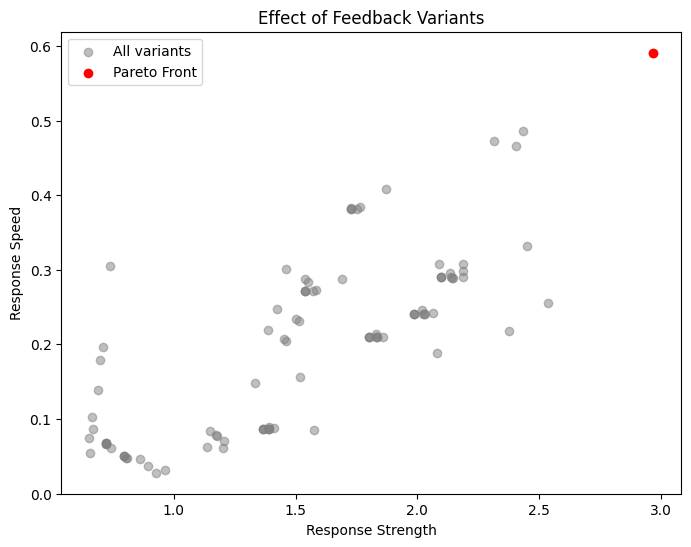

In [12]:

# Visualization
plt.figure(figsize=(8, 6))
# Plot variants
plt.scatter(df_results_var['response_strength'], df_results_var['response_speed'],  color='grey', alpha=0.5, label='All variants')
points = df_results_var[['response_strength', 'response_speed']].values
pareto_indices = calculate_pareto_front_max(points)
df_pareto = df_results_var.iloc[pareto_indices].copy()

plt.scatter(df_pareto['response_strength'], df_pareto['response_speed'], color='red', label='Pareto Front')
print(f"Pareto optimal circuits: {len(df_pareto), df_pareto['model.num']}")

plt.xlabel('Response Strength')
plt.ylabel('Response Speed')
plt.title('Effect of Feedback Variants')
plt.legend()
plt.show()